<a href="https://colab.research.google.com/github/nirkoren1/Chord_Transformer/blob/master/chord_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pickle5
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 4.7 MB/s 
     |████████████████████████████████| 5.9 MB 4.8 MB/s 
     |████████████████████████████████| 578.0 MB 17 kB/s 
     |████████████████████████████████| 438 kB 65.2 MB/s 
     |████████████████████████████████| 1.7 MB 47.8 MB/s 
     |████████████████████████████████| 5.9 MB 57.0 MB/s 


In [2]:
import tensorflow as tf
import pickle5
import pickle
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, Embedding, Flatten
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib import style
import tensorflow_datasets as tfds
import tensorflow_text
from tensorflow_text.tools.wordpiece_vocab import bert_vocab_from_dataset as bert_vocab
import tensorflow_probability as tfp

In [3]:
with open("/content/drive/MyDrive/Colab Notebooks/data.pickle", 'rb') as f:
  df = pickle5.load(f)
df

,genres,popularity,chords,training_data
0,"[canadian pop, pop, post-teen pop]",100,"[G, G/B, B, C, G, G, G/B, B, C, G, G, Em, C, G...","[<start-genres>, canadian pop, pop, post-teen ..."
1,"[canadian pop, pop, post-teen pop]",100,"[F#m7, D2, F#m7, D2, F#m7, D2, E, F#m7, A/C#, ...","[<start-genres>, canadian pop, pop, post-teen ..."
2,"[canadian pop, pop, post-teen pop]",100,"[Em, D, C, C, D, Em, Em, D, C, C, D, Em, Em, D...","[<start-genres>, canadian pop, pop, post-teen ..."
3,"[canadian pop, pop, post-teen pop]",100,"[Em, Bm, Am, C, Em, Bm, Am, C, Em, Bm, Am, C, ...","[<start-genres>, canadian pop, pop, post-teen ..."
4,"[canadian pop, pop, post-teen pop]",100,"[Gm, Dm, C, C, Gm, Dm, C, C, Gm, Dm, C, C, Gm,...","[<start-genres>, canadian pop, pop, post-teen ..."
...,...,...,...,...
135777,"[classic rock, folk, folk rock, melancholia, m...",76,"[C, Am, F, G, C, Am, F, G, C, Am, F, G, C, Am,...","[<start-genres>, classic rock, folk, folk rock..."
135778,"[classic rock, folk, folk rock, melancholia, m...",76,"[B, E, B, E, B, E, F#, E, B, F#, E, B, E, B, E...","[<start-genres>, classic rock, folk, folk rock..."
135780,"[classic rock, folk, folk rock, melancholia, m...",76,"[Dm, C, Dm, F, Bb, F, Bb, F, Bb, F, Dm, F, C, ...","[<start-genres>, classic rock, folk, folk rock..."
135781,"[classic rock, folk, folk rock, melancholia, m...",76,"[G, Em, C, G, G, Am, C, D, G, Em, C, G, G, Am,...","[<start-genres>, classic rock, folk, folk rock..."


In [4]:
train_ch = []
train_ge = []
val_ch = []
val_ge = []
val_size = 100
for index, row in df.iterrows():
  genres = row["genres"]
  genres_connected = ""
  for genre in genres:
    genres_connected += (genre + " ")
  genres_connected = genres_connected[:-1]

  chords = row["chords"]
  chords_connected = ""
  for chord in chords:
    chords_connected += (chord + " ")
  chords_connected = chords_connected[:-1]

  if index % (len(df) // val_size) == 0:
    val_ch.append(chords_connected)
    val_ge.append(genres_connected)
  else:
    train_ch.append(chords_connected)
    train_ge.append(genres_connected)

print(len(train_ch))
print(len(train_ge))
print(len(val_ch))
print(len(val_ge))
train_ch = tf.data.Dataset.from_tensor_slices(train_ch)
train_ge = tf.data.Dataset.from_tensor_slices(train_ge)
val_ch = tf.data.Dataset.from_tensor_slices(val_ch)
val_ge = tf.data.Dataset.from_tensor_slices(val_ge)

116107
116107
96
96


In [5]:
train_examples = tf.data.Dataset.zip((train_ge, train_ch))
val_examples = tf.data.Dataset.zip((val_ge, val_ch))

In [6]:
model_name = '/content/drive/MyDrive/Colab Notebooks/Transformer_project /ted_hrlr_translate_ge_ch_converter'
tokenizers = tf.saved_model.load(model_name)
print(tokenizers.ge.get_vocab_size())
print(tokenizers.ch.get_vocab_size())

tf.Tensor(976, shape=(), dtype=int32)
tf.Tensor(174, shape=(), dtype=int32)


In [7]:
max_sample_size = 256


def prepare_batch(ge, ch):
    ge = tokenizers.ge.tokenize(ge)      # Output is ragged.
    ge = ge[:, :max_sample_size]    # Trim to MAX_TOKENS.
    ge = ge.to_tensor()  # Convert to 0-padded dense Tensor

    ch = tokenizers.ch.tokenize(ch)
    ch = ch[:, :(max_sample_size + 1)]
    ch_inputs = ch[:, :-1].to_tensor()  # Drop the [END] tokens
    ch_labels = ch[:, 1:].to_tensor()   # Drop the [START] tokens

    return (ge, ch_inputs), ch_labels
BUFFER_SIZE = 20000
BATCH_SIZE = 64


def make_batches(ds):
  return (
      ds
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(prepare_batch, tf.data.AUTOTUNE)
      .prefetch(buffer_size=tf.data.AUTOTUNE))


# Create training and validation set batches.
train_batches = make_batches(train_examples)
val_batches = make_batches(val_examples)

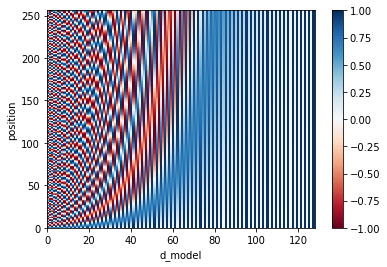

In [8]:
d_model = 128
def position_encoding(pos, i, embedding_size):
    if i % 2 == 0:
        return np.sin(pos / (10000 ** (2 * (i // 2) / embedding_size)))
    return np.cos(pos / (10000 ** (2 * (i // 2) / embedding_size)))
positional_matrix = tf.convert_to_tensor([[position_encoding(i, j, d_model) for j in range(d_model)] for i in range(max_sample_size)], dtype=tf.float32)
plt.pcolormesh(positional_matrix, cmap='RdBu')
plt.ylabel('position')
plt.xlabel('d_model')
plt.colorbar()
plt.show()

In [9]:
def add_positional_embedding(batch):
  position_embedding_sliced = positional_matrix[:tf.shape(batch)[-2], :tf.shape(batch)[-1]]
  out = batch + position_embedding_sliced[tf.newaxis, :, :]
  return out

In [10]:
largest_mask = [[0. if i >= j else 1 for j in range(max_sample_size)] for i in range(max_sample_size)]
largest_mask = tf.convert_to_tensor(largest_mask, dtype=tf.float32)
def look_ahead_mask(batch):
  return largest_mask[tf.newaxis, :tf.shape(batch)[1], :tf.shape(batch)[1]]

def padding_mask(keys_tekenized):
    mask = tf.cast(tf.math.equal(keys_tekenized, 0), tf.float32)
    return mask[:, tf.newaxis, :]

def padding_and_look_ahead_mask(batch):
  return tf.maximum(padding_mask(batch), look_ahead_mask(batch))

for (ru, en), en_val in train_batches:
  print(en)
  ex = tf.convert_to_tensor([[[np.random.random() for _ in range(en.shape[-1])] for _ in range(ru.shape[-1])] for _ in range(BATCH_SIZE)], dtype=tf.float32)
  mask = padding_mask(en)
  ex += (-1e9 * mask)
  print(ex)
  ex2 = tf.convert_to_tensor([[[np.random.random() for _ in range(en.shape[-1])] for _ in range(en.shape[-1])] for _ in range(BATCH_SIZE)], dtype=tf.float32)
  ex2 += (-1e9 * padding_and_look_ahead_mask(en))
  print(ex2)
  break

tf.Tensor(
[[ 2 37 28 ...  0  0  0]
 [ 2 64 14 ...  4 10 20]
 [ 2 14 16 ...  0  0  0]
 ...
 [ 2 20 17 ...  0  0  0]
 [ 2 20 20 ...  0  0  0]
 [ 2 22 16 ...  0  0  0]], shape=(64, 256), dtype=int64)
tf.Tensor(
[[[ 5.13268530e-01  7.01880024e-04  9.13972855e-02 ... -1.00000000e+09
   -1.00000000e+09 -1.00000000e+09]
  [ 6.50307953e-01  1.96241572e-01  7.84025133e-01 ... -1.00000000e+09
   -1.00000000e+09 -1.00000000e+09]
  [ 5.62433362e-01  9.78237152e-01  9.39592779e-01 ... -1.00000000e+09
   -1.00000000e+09 -1.00000000e+09]
  ...
  [ 1.44303411e-01  3.99976164e-01  6.58552408e-01 ... -1.00000000e+09
   -1.00000000e+09 -1.00000000e+09]
  [ 8.09785247e-01  3.99858326e-01  8.66922960e-02 ... -1.00000000e+09
   -1.00000000e+09 -1.00000000e+09]
  [ 7.13636518e-01  6.99867845e-01  4.94628608e-01 ... -1.00000000e+09
   -1.00000000e+09 -1.00000000e+09]]

 [[ 6.98780358e-01  1.15399808e-01  7.65430555e-02 ...  2.26248607e-01
    3.47998721e-04  1.34055465e-01]
  [ 6.14607871e-01  1.50096416e-01

In [11]:
def attention_head(q, k, v, mask):
  dk = tf.shape(q)[-1]
  q = tf.scalar_mul(1 / tf.math.sqrt(tf.cast(dk, tf.float32)), q)
  QK = tf.linalg.matmul(q, k, transpose_b=True)
  QK += (mask * -1e9)
  QK = tf.nn.softmax(QK, axis=-1)
  QKV = tf.linalg.matmul(QK, v)
  return QKV


In [12]:
class MultiHeadAttention(keras.layers.Layer):
  def __init__(self, d_model, h: int, dropout_rate=0.1):
    super(MultiHeadAttention, self).__init__()
    self.h = h
    self.d_model = d_model
    self.dk = d_model / h
    self.normalize = LayerNormalization(axis=-1, center=True, scale=True, epsilon=0.0001)
    self.fc = Dense(d_model)
    self.dropout = Dropout(dropout_rate)
    self.value_weights = Dense(d_model)
    self.query_weights = Dense(d_model)
    self.key_weights = Dense(d_model)
    self.add = keras.layers.Add()

  def call(self, q, k, v, mask, training=False, use_causal_mask=False):
    query = self.query_weights(q)
    key = self.key_weights(k)
    value = self.value_weights(v)
    query = tf.split(query, self.h, axis=-1)
    key = tf.split(key, self.h, axis=-1)
    value = tf.split(value, self.h, axis=-1)
    attentions = [attention_head(query[i], key[i], value[i], mask) for i in range(self.h)]
    result = tf.concat(attentions, -1)
    result = self.fc(result)
    if training:
      result = self.dropout(result)
    result = self.add([result, q])
    result = self.normalize(result)
    return result

In [13]:
class FeedForwardBlock(keras.layers.Layer):
  def __init__(self, d_model, hidden_layer_size, dropout_rate=0.1):
    super(FeedForwardBlock, self).__init__()
    self.fc1 = Dense(hidden_layer_size, activation="relu")
    self.fc2 = Dense(d_model)
    self.normalize = LayerNormalization(axis=-1, center=True, scale=True, epsilon=0.0001)
    self.dropout = Dropout(dropout_rate)
    self.add = keras.layers.Add()

  def call(self, input_tensor, training=False):
    result = self.fc1(input_tensor)
    result = self.fc2(result)
    if training:
      result = self.dropout(result)
    result = self.add([result, input_tensor])
    result = self.normalize(result)
    return result

In [14]:
class EncoderLayer(keras.layers.Layer):
  def __init__(self, d_model, h, ff_size):
    super(EncoderLayer, self).__init__()
    self.mha = MultiHeadAttention(d_model, h)
    self.ff = FeedForwardBlock(d_model, ff_size)

  def call(self, input_tensor, mask, training=False):
    result = self.mha(input_tensor, input_tensor, input_tensor, mask, training=training)
    result = self.ff(result, training=training)
    return result

In [15]:
class Encoder(keras.layers.Layer):
  def __init__(self, d_model, h, encoder_dict_size, ff_size, N=4):
    super().__init__()
    self.N = N
    self.d_model = d_model
    self.h = h
    self.embedding = Embedding(encoder_dict_size, d_model, mask_zero=True)
    self.encoder_layers = [EncoderLayer(d_model, h, ff_size) for _ in range(N)]

  def call(self, encoder_input, training=False):
    mask = padding_mask(encoder_input)
    result = self.embedding(encoder_input)
    result *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    result = add_positional_embedding(result)
    for i in range(self.N):
      result = self.encoder_layers[i](result, mask, training=training)
    return result

In [16]:
class DecoderLayer(keras.layers.Layer):
  def __init__(self, d_model, h, ff_size):
    super(DecoderLayer, self).__init__()
    self.mha_self = MultiHeadAttention(d_model, h)
    self.mha_cross = MultiHeadAttention(d_model, h)
    self.ff = FeedForwardBlock(d_model, ff_size)

  def call(self, input_tensor, encoder_output, encoder_mask, decoder_mask, training=False):
    result = self.mha_self(input_tensor, input_tensor, input_tensor, decoder_mask, training=training, use_causal_mask=True)
    result = self.mha_cross(result, encoder_output, encoder_output, encoder_mask, training=training)
    result = self.ff(result, training=training)
    return result

In [17]:
class Decoder(keras.layers.Layer):
  def __init__(self, d_model, h, decoder_dict_size, ff_size, N=4):
    super().__init__()
    self.N = N
    self.d_model = d_model
    self.h = h
    self.embedding = Embedding(decoder_dict_size, d_model, mask_zero=True)
    self.decoder_layers = [DecoderLayer(d_model, h, ff_size) for _ in range(N)]

  def call(self, decoder_input, encoder_out, encoder_mask, training=False):
    decoder_mask = padding_and_look_ahead_mask(decoder_input)
    result = self.embedding(decoder_input)
    result *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    result = add_positional_embedding(result)
    for i in range(self.N):
      result = self.decoder_layers[i](result, encoder_out, encoder_mask, decoder_mask, training=training)
    return result

In [18]:
class Transformer(keras.Model):
  def __init__(self, d_model, h, encoder_dict_size, decoder_dict_size, ff_size):
        super().__init__()
        self.d_model = d_model
        self.encoder = Encoder(d_model, h, encoder_dict_size, ff_size)
        self.decoder = Decoder(d_model, h, decoder_dict_size, ff_size)
        self.final_layer = Dense(decoder_dict_size)

        self.accs = []
        self.losses_lst = []

  def call(self, inputs, training=False):
      encoder_input_tokenized, decoder_input_tokenized = inputs
      encoder_output = self.encoder(encoder_input_tokenized, training)
      decoder_output = self.decoder(decoder_input_tokenized, encoder_output, padding_mask(encoder_input_tokenized), training)
      result = self.final_layer(decoder_output)
      return result

  def get_acc_moving_avg(self, window_size=50):
    if len(self.accs) < window_size:
      return sum(self.accs) / len(self.accs)
    return sum(self.accs[-window_size:]) / window_size

  def get_loss_moving_avg(self, window_size=50):
    if len(self.losses_lst) < window_size:
      return sum(self.losses_lst) / len(self.losses_lst)
    return sum(self.losses_lst[-window_size:]) / window_size

transformer_ex = Transformer(d_model, 8, tokenizers.ge.get_vocab_size(), tokenizers.ch.get_vocab_size(), 1024)
i = 0
for inputs, ch_val in train_batches:
  i += 1
  print(transformer_ex(inputs))
  if i == 2:
    break

tf.Tensor(
[[[ 0.22532292  1.5838974   1.3114774  ...  1.1366242   0.5711245
   -0.849296  ]
  [ 0.22760941  1.6619028   1.164714   ...  1.056908    0.51478547
   -0.8104961 ]
  [ 0.20913595  1.6134107   1.2167169  ...  1.0499895   0.6109317
   -0.8089359 ]
  ...
  [ 0.36935833  1.541748    1.2292484  ...  1.1898419   0.760216
   -0.7982413 ]
  [ 0.39543888  1.549747    1.2666312  ...  1.1871165   0.7996808
   -0.77342004]
  [ 0.41747448  1.5552145   1.2892773  ...  1.1852411   0.8169272
   -0.7466456 ]]

 [[-0.04304248  1.4264886   1.286507   ...  1.2557197   0.57252437
   -0.60530996]
  [-0.11217072  1.4952819   1.1472827  ...  1.2315533   0.5421095
   -0.6477015 ]
  [-0.11662231  1.4586433   1.193175   ...  1.2331877   0.61248493
   -0.642166  ]
  ...
  [ 0.13825455  1.3296766   1.0882362  ...  1.3703239   0.7872299
   -0.68142986]
  [ 0.16660476  1.3293637   1.1108449  ...  1.3720123   0.8393555
   -0.66322416]
  [ 0.18736863  1.3376278   1.1252574  ...  1.3665034   0.84439474
   -

In [19]:
transformer_ex.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1444352   
                                                                 
 decoder (Decoder)           multiple                  1606912   
                                                                 
 dense_64 (Dense)            multiple                  22446     
                                                                 
Total params: 3,073,710
Trainable params: 3,073,710
Non-trainable params: 0
_________________________________________________________________


In [20]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [21]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [22]:
def masked_loss(label, pred):
  mask = label != 0
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
  loss = loss_object(label, pred)

  mask = tf.cast(mask, dtype=loss.dtype)
  loss *= mask

  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_accuracy(label, pred):
  pred = tf.argmax(pred, axis=2)
  label = tf.cast(label, pred.dtype)
  match = label == pred

  mask = label != 0

  match = match & mask

  match = tf.cast(match, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [23]:
transformer_ex.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

In [24]:
transformer_ex.fit(train_batches,
                epochs=3,
                validation_data=val_batches)

Epoch 1/3
1815/1815 [==============================] - 370s 190ms/step - loss: 2.0312 - masked_accuracy: 0.4220 - val_loss: 1.2691 - val_masked_accuracy: 0.6334
Epoch 2/3
1815/1815 [==============================] - 344s 190ms/step - loss: 1.1341 - masked_accuracy: 0.6802 - val_loss: 0.9662 - val_masked_accuracy: 0.7332
Epoch 3/3
1815/1815 [==============================] - 347s 191ms/step - loss: 0.9917 - masked_accuracy: 0.7226 - val_loss: 0.9139 - val_masked_accuracy: 0.7505


In [34]:
class Translator(tf.Module):
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, genres, start_chords, randomness=False, max_length=max_sample_size):
    assert isinstance(genres, tf.Tensor)
    if len(genres.shape) == 0:
      genres = genres[tf.newaxis]

    genres = self.tokenizers.ge.tokenize(genres).to_tensor()

    encoder_input = genres

    # As the output language is English, initialize the output with the
    # English `[START]` token.
    start_end = self.tokenizers.ch.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    start_chords_tokenized = self.tokenizers.ch.tokenize([start_chords])[0]
    j = -1
    for j in tf.range(tf.shape(start_chords_tokenized)[0] - 2):
      token = start_chords_tokenized[j + 1][tf.newaxis]
      output_array = output_array.write(j + 1, token)

    for i in tf.range(max_length - j - 1):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=True)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.
      if randomness:
        predictions = tf.nn.softmax(predictions * 1.05, axis=-1)
        dist = tfp.distributions.Categorical(probs=predictions[0][0])
        index = dist.sample()
        predicted_id = tf.cast(index[tf.newaxis][tf.newaxis], dtype=tf.int64)
      else:
        predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i + 1 + j + 1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # The output shape is `(1, tokens)`.
    text = tokenizers.ch.detokenize(output)[0]  # Shape: `()`.

    tokens = tokenizers.ch.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # Therefore, recalculate them outside the loop.
    # _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens

In [35]:
def print_translation(sentence, tokens):
  print(f'{"Input:":15s}: {sentence}')
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')

In [36]:
translator = Translator(tokenizers, transformer_ex)

In [37]:
def print_example():
  genres = 'adult standards contemporary vocal jazz jazz pop neo mellow vocal jazz'
  start_chords = ''

  generated_chords, translated_tokens = translator(
      tf.constant(genres), tf.constant(start_chords), randomness=True)
  print()
  print_translation(genres, generated_chords)
  print()
print_example()


Input:         : adult standards contemporary vocal jazz jazz pop neo mellow vocal jazz
Prediction     : d c # m e a b a e a b a e b a e a b a e a b a e a b a e a b a e a e a d d a e a b a e d

